In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score 
from time import time
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import seaborn as sns

In [7]:
scaler = StandardScaler() 

train_eval_split = .8

train = pd.read_csv('playground-series-s4e5/train.csv')

train, eval = train_test_split(train, train_size = train_eval_split)

columns = list(train.columns)
columns = [columns[i] for i in range(len(columns)) if columns[i] != 'id' and columns[i] != 'FloodProbability']

train[columns] = scaler.fit_transform(train[columns])
eval[columns] = scaler.fit_transform(eval[columns])

X_train, y_train = train[columns][:100000], train['FloodProbability'][:100000]
X_eval, y_eval = eval[columns][:20000], eval['FloodProbability'][:20000]

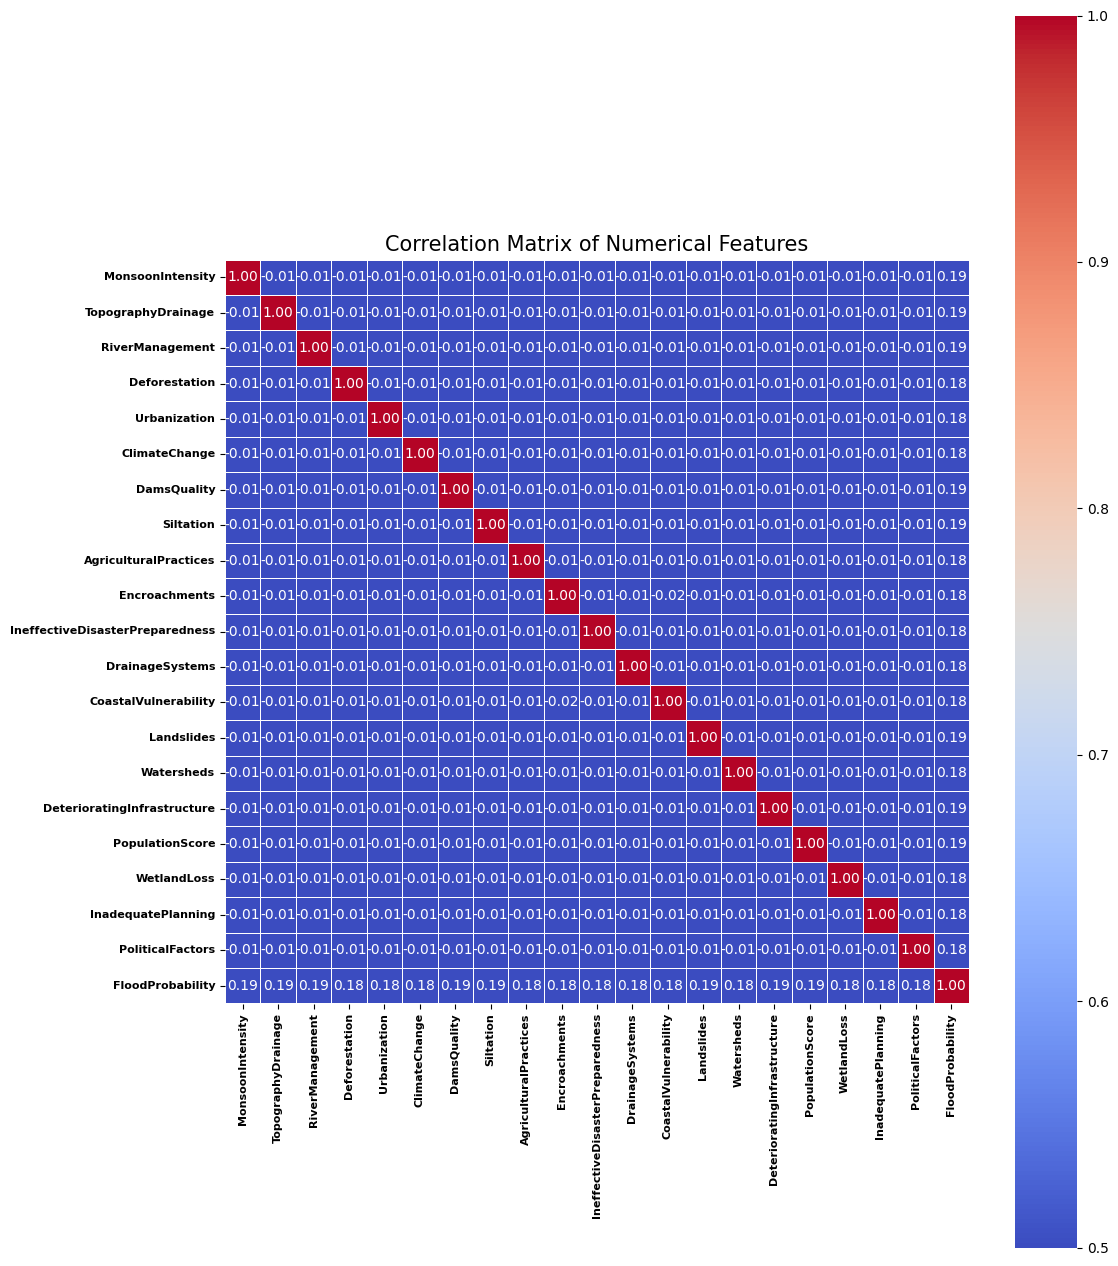

In [4]:
corr_matrix = train.drop(['id'], axis = 1).corr()
plt.figure(figsize=(12, 16))
sns.heatmap(corr_matrix, vmax=1, vmin=0.5, center=0.75,annot=True, fmt=".2f", square=True, 
            linewidths=.5, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.xticks(fontsize=8,fontweight='bold')
plt.yticks(fontsize=8,fontweight='bold')
plt.show()

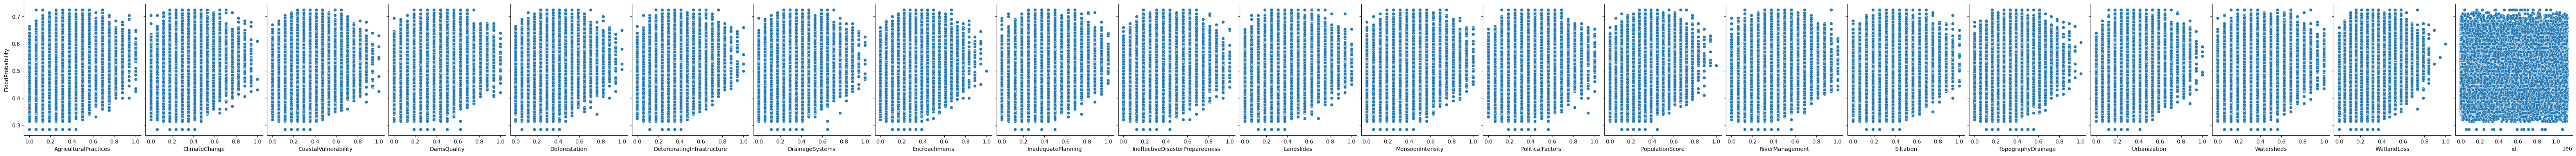

In [97]:
sns.pairplot(train, y_vars=['FloodProbability'], x_vars=train.columns.difference(['FloodProbability']), height=4, aspect=0.8)
plt.show()

In [5]:
def fit_and_test(X_train, y_train, X_eval, y_eval, model):

    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_train = pd.Series(y_pred_train, index = X_train.index, name = 'Predictions')
    train_acc = r2_score(y_true = y_train, y_pred = y_pred_train)

    y_pred_eval = model.predict(X_eval)
    y_pred_eval = pd.Series(y_pred_eval, index = X_eval.index, name = 'Predictions')
    eval_acc = r2_score(y_true = y_eval, y_pred = y_pred_eval)

    return train_acc, eval_acc

In [9]:
min_sample_split_train_acc = []
min_sample_split_eval_acc = []

min_sample_splits = [i for i in range(750, 1000, 50)]

start = time()

for min_sample_split in min_sample_splits:

    model = RandomForestRegressor(n_estimators = min_sample_split, 
                                  random_state = 1, 
                                  min_samples_split = 2, 
                                  min_samples_leaf = 2,
                                  max_depth = 30,
                                  n_jobs = -1,  
                                  verbose = False)
    
    train_acc, eval_acc = fit_and_test(X_train = X_train, y_train = y_train, X_eval = X_eval, y_eval = y_eval, model = model)

    min_sample_split_train_acc.append(train_acc)
    min_sample_split_eval_acc.append(eval_acc)
    end = time()

    print(f'Iteration for {min_sample_split} estimatorss finished, Test: {train_acc:.3f}, Eval: {eval_acc:.3f}')
    print('-------------------------------------------------------')
    print(f'Elapsed time: {(end-start)/60:.1f} min') 
    print('=======================================================')
    start = time()

min_sample_split_train_acc, min_sample_split_eval_acc  

Iteration for 750 estimatorss finished, Test: 0.930, Eval: 0.624
-------------------------------------------------------
Elapsed time: 1.0 min
Iteration for 800 estimatorss finished, Test: 0.930, Eval: 0.624
-------------------------------------------------------
Elapsed time: 1.1 min
Iteration for 850 estimatorss finished, Test: 0.930, Eval: 0.624
-------------------------------------------------------
Elapsed time: 1.2 min
Iteration for 900 estimatorss finished, Test: 0.930, Eval: 0.624
-------------------------------------------------------
Elapsed time: 1.3 min
Iteration for 950 estimatorss finished, Test: 0.930, Eval: 0.624
-------------------------------------------------------
Elapsed time: 1.4 min


([0.9301804980109393,
  0.9302089820357735,
  0.9302200167156095,
  0.9302362166216774,
  0.930251184271051],
 [0.6242898550306912,
  0.6243411908078351,
  0.6243520124669463,
  0.6244145106357585,
  0.6243999450001236])

In [ ]:
plt.plot(min_sample_splits, min_sample_split_train_acc)
plt.plot(min_sample_splits, min_sample_split_eval_acc)
plt.xlabel('Number of etimatorst')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

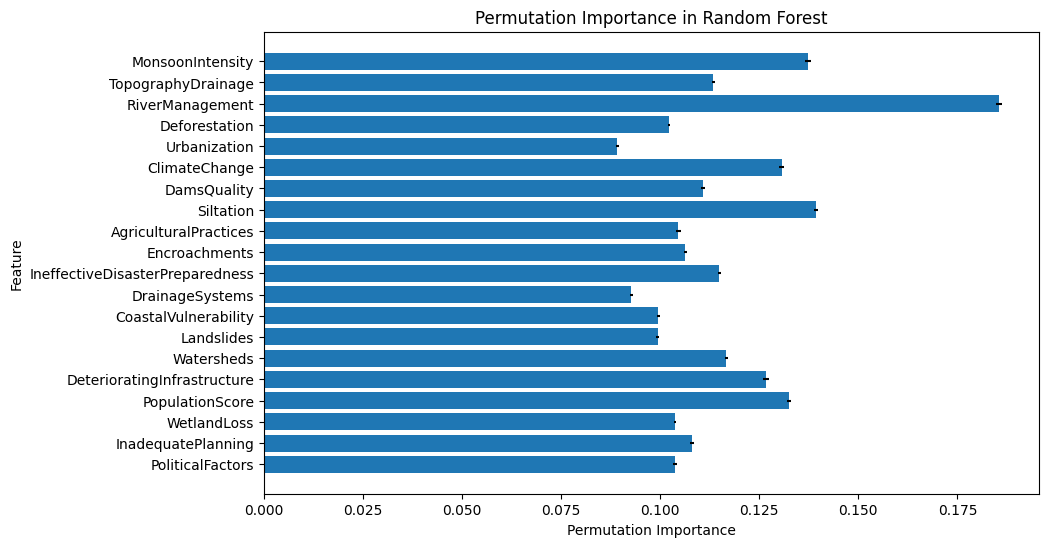

In [81]:
model = RandomForestRegressor(n_estimators = 500, 
                                  random_state = 1, 
                                  min_samples_split = 2, 
                                  min_samples_leaf = 2,
                                  max_depth = 30,
                                  n_jobs = -1,  
                                  verbose = False)

model.fit(X_train, y_train)

result = permutation_importance(model, X_train, y_train, n_repeats = 10, random_state = 1, n_jobs = -1)

importances = result.importances_mean
importances_std = result.importances_std

feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'importance_std': importances_std})

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], xerr=feature_importance_df['importance_std'])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()